# Census Income Project

### Problem Statement:

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

##### Description of fnlwgt (final weight)

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

- A single cell estimate of the population 16+ for each state.

- Controls for Hispanic Origin by age and sex.

- Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.

In [1]:
# Importing the libraries.
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt

from scipy.stats import zscore
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

Importing all the necessary libraries.

In [2]:
df = pd.read_csv(r"census.csv")

downloaded the entire data set into my system and saved it as a csv file and imported the dataset using pandas library.

In [3]:
df

Age          Workclass  Fnlwgt    Education  Education_num  \
0       50   Self-emp-not-inc   83311    Bachelors             13   
1       38            Private  215646      HS-grad              9   
2       53            Private  234721         11th              7   
3       28            Private  338409    Bachelors             13   
4       37            Private  284582      Masters             14   
...    ...                ...     ...          ...            ...   
32555   27            Private  257302   Assoc-acdm             12   
32556   40            Private  154374      HS-grad              9   
32557   58            Private  151910      HS-grad              9   
32558   22            Private  201490      HS-grad              9   
32559   52       Self-emp-inc  287927      HS-grad              9   

            Marital_status          Occupation    Relationship    Race  \
0       Married-civ-spouse     Exec-managerial         Husband   White   
1                 Divorced   Handlers-cleaners   Not-in-family   White   
2       Married-civ-spouse   Handlers-cleaners         Husband   Black   
3       Married-civ-spouse      Prof-specialty            Wife   Black   
4       Married-civ-spouse     Exec-managerial            Wife   White   
...                    ...                 ...             ...     ...   
32555   Married-civ-spouse        Tech-support            Wife   White   
32556   Married-civ-spouse   Machine-op-inspct         Husband   White   
32557              Widowed        Adm-clerical       Unmarried   White   
32558        Never-married        Adm-clerical       Own-child   White   
32559   Married-civ-spouse     Exec-managerial            Wife   White   

           Sex  Capital_gain  Capital_loss  Hours_per_week  Native_country  \
0         Male             0             0              13   United-States   
1         Male             0             0              40   United-States   
2         Male             0             0              40   United-States   
3       Female             0             0              40            Cuba   
4       Female             0             0              40   United-States   
...        ...           ...           ...             ...             ...   
32555   Female             0             0              38   United-States   
32556     Male             0             0              40   United-States   
32557   Female             0             0              40   United-States   
32558     Male             0             0              20   United-States   
32559   Female         15024             0              40   United-States   

       Income  
0       <=50K  
1       <=50K  
2       <=50K  
3       <=50K  
4       <=50K  
...       ...  
32555   <=50K  
32556    >50K  
32557   <=50K  
32558   <=50K  
32559    >50K  

[32560 rows x 15 columns]

In the above cell we can see the first 5 and last 5 rows of our dataset. We see that in our dataset there are a total of 32560 rows and 15 columns present. We see a mixture of numerical data columns and text data columns that will need to be converted to numerical format before training our model. Also the problem statement says that we are supposed to predict the "Income" column that has 2 class namely "<=50K" and ">50K" so it makes this as a Classification problem.

# Exploratory Data Analysis (EDA)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Ensuring that in future observations we do not have any truncated information being displayed in our Jupter Notebook.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32560 entries, 0 to 32559
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32560 non-null  int64 
 1   Workclass       32560 non-null  object
 2   Fnlwgt          32560 non-null  int64 
 3   Education       32560 non-null  object
 4   Education_num   32560 non-null  int64 
 5   Marital_status  32560 non-null  object
 6   Occupation      32560 non-null  object
 7   Relationship    32560 non-null  object
 8   Race            32560 non-null  object
 9   Sex             32560 non-null  object
 10  Capital_gain    32560 non-null  int64 
 11  Capital_loss    32560 non-null  int64 
 12  Hours_per_week  32560 non-null  int64 
 13  Native_country  32560 non-null  object
 14  Income          32560 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Using the info method we can see that there are 6 columns with integer data type and 9 columns that have object data type. We will try to spearate these columns for easier analysis purpose.

In [6]:
# getting list of object data type column names
object_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'object':
        object_datatype.append(x)
print(f"Object Data Type Columns are: ", object_datatype)

Object Data Type Columns are:  ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']


In [7]:
# getting the list of float data type column names
integer_datatype = []
for x in df.dtypes.index:
    if df.dtypes[x] == 'int64':
        integer_datatype.append(x)
print(f"\nFloat Data Type Columns are: ", integer_datatype)


Float Data Type Columns are:  ['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']


We have successfully bifurcated the object datatype column names and integer data type column names. Since we do not have to worry about outliers and skewness in categorical columns we can use this separated column names to pre process only on numerical continous columns.

### Statistical Summary

In [8]:
df.describe()

Age        Fnlwgt  Education_num  Capital_gain  Capital_loss  \
count  32560.000000  3.256000e+04   32560.000000  32560.000000  32560.000000   
mean      38.581634  1.897818e+05      10.080590   1077.615172     87.306511   
std       13.640642  1.055498e+05       2.572709   7385.402999    402.966116   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178315e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783630e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370545e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       Hours_per_week  
count    32560.000000  
mean        40.437469  
std         12.347618  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

Using the describe method we can take a look at the numerical data type columns and observe the distribution of integer data amongst them. The first column shows the count/rows occupied by the columns and since all of them have the same number it indicates that there are no missing values in them. Moving on to other columns I see abnormality in the columns "Capital_gain" and "Capital_loss" that have the value 0.0 for minimum value, 25% data slot, 50% data slot and 75% data slot. However the maximum values are quite huge in number so they might be termed as some kind of outlier but when we speak statistically such kind of data is possible and therefore we will either retain them or treat them accordingly as per our requirement.

In [9]:
df.isna().sum()

Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

It looks like we do not have any missing data present in our dataset for any of the columns.

<AxesSubplot:>

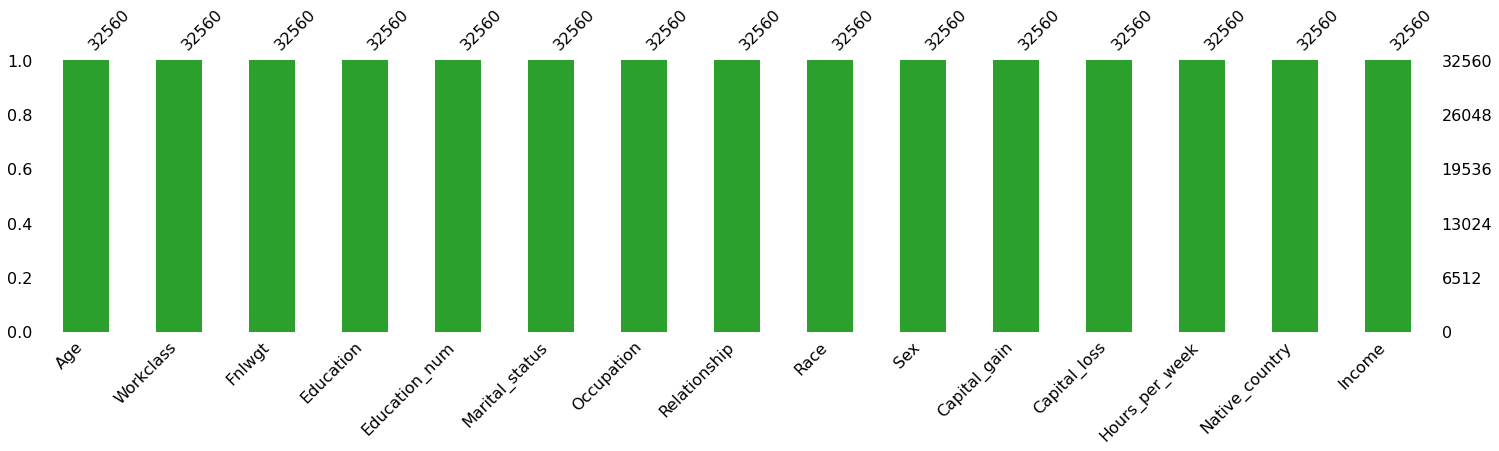

In [10]:
missingno.bar(df, figsize = (25,5), color="tab:green")

We are able to depict the missing values information in a bar plot format where we can clearly see that all the columns have all the rows filled with data and there are no null values present.

In [11]:
print(f"Rows and Columns before dropping duplicates: ", df.shape)
df.drop_duplicates(inplace=True)
print(f"Rows and Columns after dropping duplicates: ", df.shape)

Rows and Columns before dropping duplicates:  (32560, 15)
Rows and Columns after dropping duplicates:  (32536, 15)


With the drop_duplicates option I am getting rid of all the duplicate values rows present in our dataset.

In [12]:
df.nunique().to_frame("Unique Values")

Unique Values
Age                        73
Workclass                   9
Fnlwgt                  21647
Education                  16
Education_num              16
Marital_status              7
Occupation                 15
Relationship                6
Race                        5
Sex                         2
Capital_gain              119
Capital_loss               92
Hours_per_week             94
Native_country             42
Income                      2

The nunique method lists down the number of all the unique data present in each column of our dataset.

In [13]:
for col in object_datatype:
    print(col)
    print(df[col].value_counts())
    print("="*80)

Workclass
 Private             22673
 Self-emp-not-inc     2540
 Local-gov            2093
 ?                    1836
 State-gov            1297
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64
Education
 HS-grad         10494
 Some-college     7282
 Bachelors        5352
 Masters          1722
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           645
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           332
 1st-4th           166
 Preschool          50
Name: Education, dtype: int64
Marital_status
 Married-civ-spouse       14970
 Never-married            10666
 Divorced                  4441
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital_status, dtype: int64
Occupation
 Prof-specialty       41

In the above cell we are taking a look at all the unique values of object data type columns. While eye balling the values we were able to see data that showed "?" in the columns "Workclass", "Occupation" and "Native_country". We will need to replace all the rows that have this "?" in them with a proper name first so that during visualizing and later on encoding these values makes more sense.

In [14]:
df['Workclass'].replace({' ?':' Other-Working-Class'},inplace=True)
df['Occupation'].replace({' ?':' Other-Occupation'},inplace=True)
df['Native_country'].replace({' ?':' Others'},inplace=True)

We have successfully replaced all the "?" data present in the columns "Workclass", "Occupation" and "Native_country" with meaningful values.

# Data Visualization

In [15]:
print(f"Object Data Type Column Names: ", object_datatype)
print(f"\nInteger Data Type Column Names: ", integer_datatype)

Object Data Type Column Names:  ['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native_country', 'Income']

Integer Data Type Column Names:  ['Age', 'Fnlwgt', 'Education_num', 'Capital_gain', 'Capital_loss', 'Hours_per_week']


Lisiting out the column names for object datatype and integer datatype respectively.

### Univariate Analysis (Categorical columns)

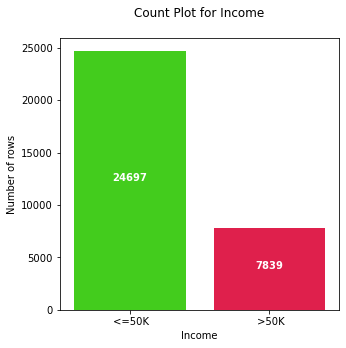

In [16]:
#Visualize the whether the income is above 50K or not
try:
    plt.figure(figsize=(5,5))
    col_name = 'Income'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above count plot we can see that our target label "Income" column has imbalaned dataset that will need to be taken care of before we start building our classification machine learning model.

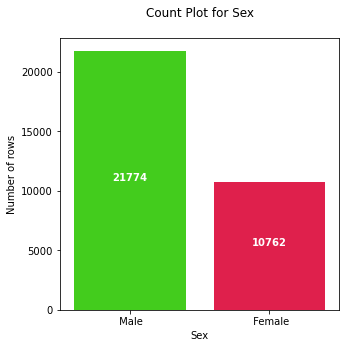

In [17]:
try:
    plt.figure(figsize=(5,5))
    col_name = 'Sex'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above count plot we can see that the number of data values for male is higher than that of it's female counterparts.

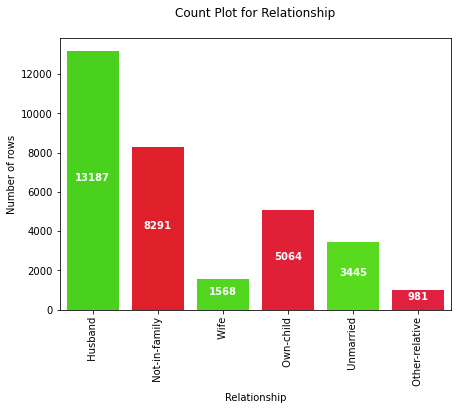

In [18]:
try:
    plt.figure(figsize=(7,5))
    col_name = 'Relationship'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above count plot we see that in the "Relationship" status the values for husband is the highest and other relative has the lowest data.

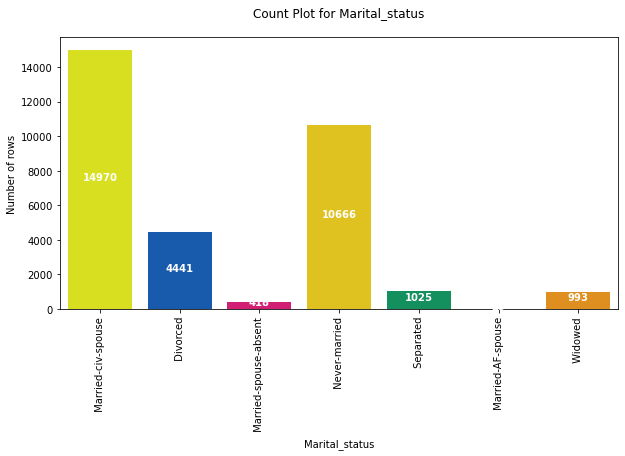

In [19]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Marital_status'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that the Marital Status column has married spouse and never married people on the higher edge as compared to the other values.

In [20]:
try:
    plt.figure(figsize=(10,5))
    col_name = 'Race'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that the Race column mostly comprises of White people in the dataset.

In [21]:
try:
    plt.figure(figsize=(12,5))
    col_name = 'Workclass'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that in the Work Class column the highest number of people work for private sector and the other work classes or people who are unemployed is quite less to negligible.

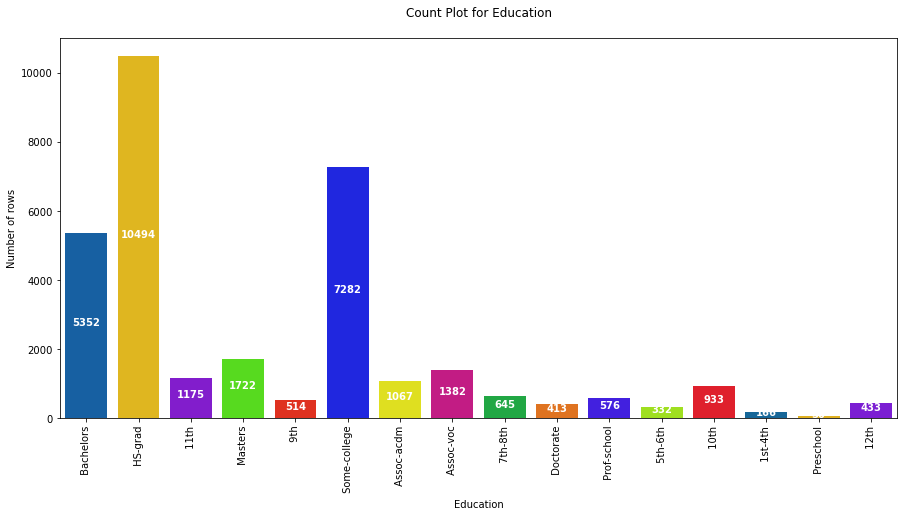

In [22]:
try:
    plt.figure(figsize=(15,7))
    col_name = 'Education'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we see that the Education column has the highest number of values in HS grad followed by Some college and Bachelors. Remaining education categories have quite lesser data coverage in our dataset.

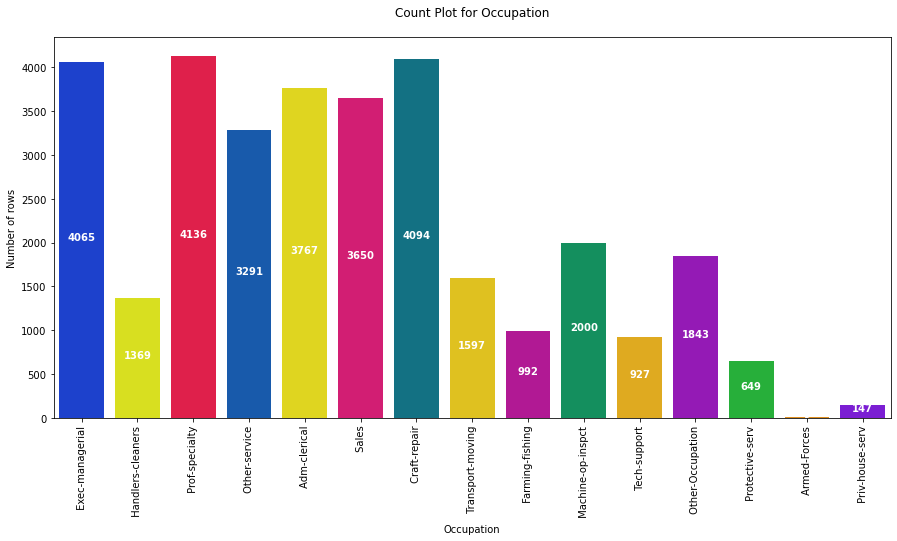

In [23]:
try:
    plt.figure(figsize=(15,7))
    col_name = 'Occupation'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we can see that the Occupation column has various categories out of which people in Armed Forces are the least and folks engaged in some craft repair, executive managers and holding some professional speciality are on the rise.

In [24]:
try:
    plt.figure(figsize=(18,7))
    col_name = 'Native_country'
    values = df[col_name].value_counts()
    index = 0
    ax = sns.countplot(df[col_name], palette="prism")

    for i in ax.get_xticklabels():
        ax.text(index, values[i.get_text()]/2, values[i.get_text()], 
                horizontalalignment="center", fontweight='bold', color='w')
        index += 1
    
    plt.title(f"Count Plot for {col_name}\n")
    plt.ylabel(f"Number of rows")
    plt.xticks(rotation=90)
    plt.show()
    
except Exception as e:
    print("Error:", e)
    pass

From the above countplot we can clearly see that the Native Country column has the highest value for US followed by Mexico and Others while the remaining categories has the least to neligible amount of data coverage.

### Bivariate Analysis

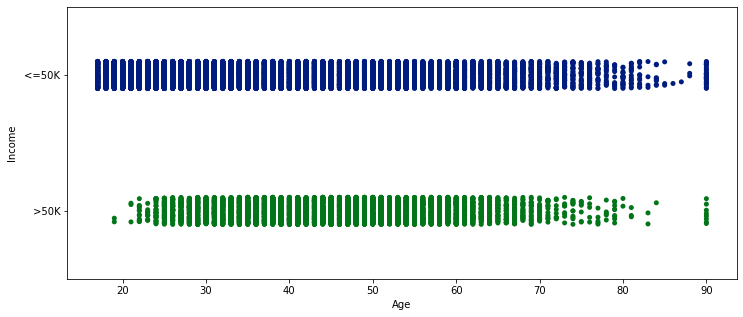

In [25]:
plt.style.use('seaborn-dark-palette')
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Age', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that young people hardly have income more than 50K.

In [26]:
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Hours_per_week', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that people who have income less than or equal to 50K put in more hours per week as compared to the one's who earn more than 50K as income.

In [27]:
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Fnlwgt', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the final weight has data coverage on a higher scale for people in the <=50K income bracket as compared to the people in >50K income bracket.

In [28]:
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Education_num', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the lower education number is almost negligibe for people with income >50K and it therefore emphasizes on the importance of education too.

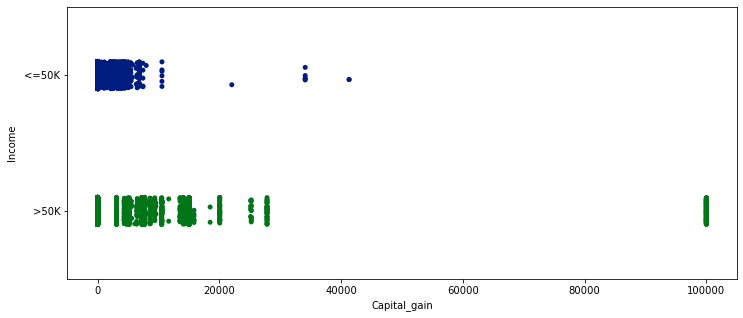

In [29]:
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Capital_gain', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the capital gain is on a higher scale for people with income >50K

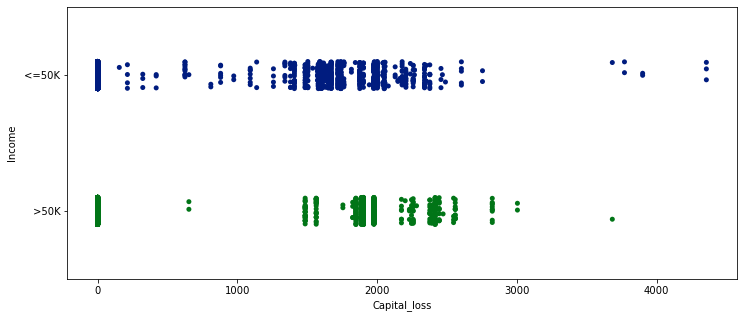

In [30]:
plt.figure(figsize=(12,5))
sns.stripplot(x = 'Capital_loss', y = 'Income', data=df)
plt.show()

In the above strip plot we can see that the capital loss for people with income >50K is considerably less than people with income <=50K

In [31]:
plt.style.use('ggplot')
tbl = pd.crosstab(df['Race'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Race/Ethenicity details', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

Text(0, 0.5, 'Percentage of People')

The above cross tab bar plot shows us different ethenicity race group folks and the income variations between them.

Text(0, 0.5, 'Percentage of People')

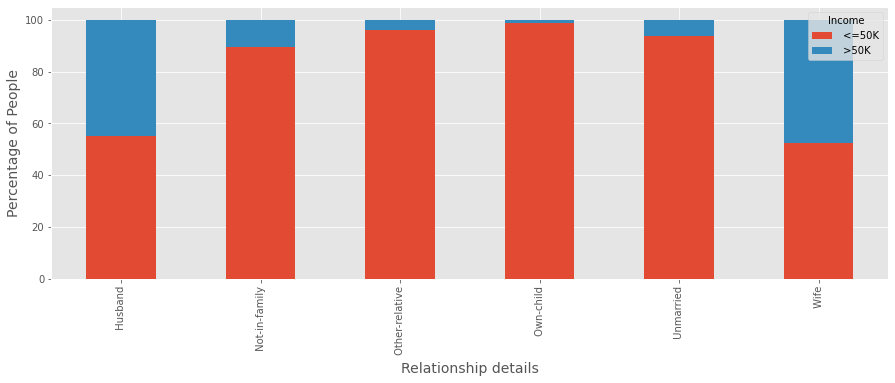

In [32]:
tbl = pd.crosstab(df['Relationship'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Relationship details', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the difference in income details for people in different relationship status. People who are earning >50K are mostly from the relationship status husband or wife.

Text(0, 0.5, 'Percentage of People')

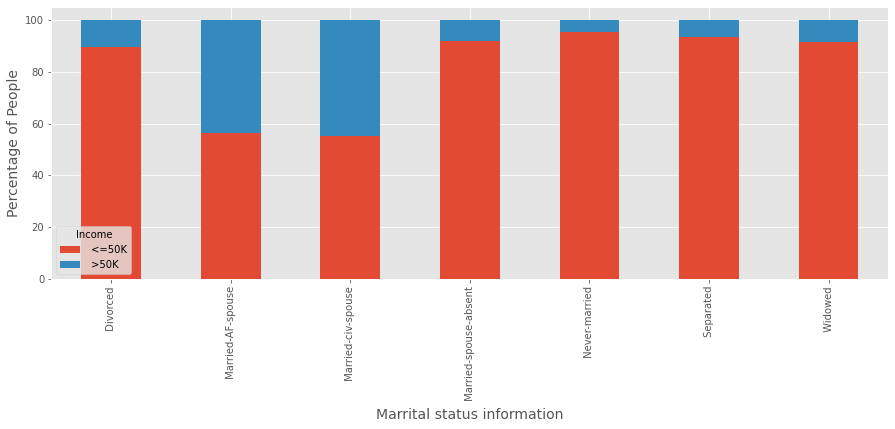

In [33]:
tbl = pd.crosstab(df['Marital_status'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Marrital status information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the marrital status of people who have income either <=50K or >50K.

Text(0, 0.5, 'Percentage of People')

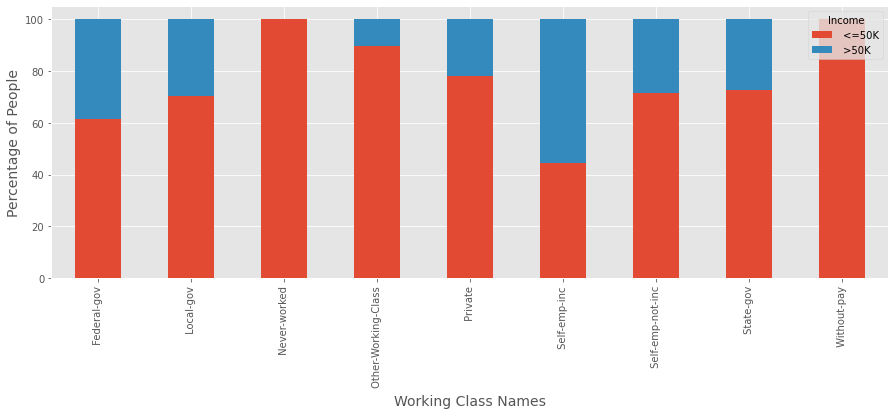

In [34]:
tbl = pd.crosstab(df['Workclass'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Working Class Names', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

The above cross tab bar plot shows us the working class information and people who have never worked or are sitting without pay obviously come under <=50K income bracket while mostly people who are self employed or own a business are able to make an income of >50K.

In [35]:
tbl = pd.crosstab(df['Education_num'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Education Number information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

Text(0, 0.5, 'Percentage of People')

The above cross tab bar plot shows us the education number scale which indicated that to earn an income of >50K you need to have a higher educational number emphasizing the importance on the educational front.

In [36]:
tbl = pd.crosstab(df['Education'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Education information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

Text(0, 0.5, 'Percentage of People')

The above cross tab bar plot shows us the different education types for people and their income scale. It looks like people with >50K income have a qualification in doctorate, masters and professional school.

In [37]:
tbl = pd.crosstab(df['Occupation'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Occupation details', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

Text(0, 0.5, 'Percentage of People')

The above cross tab bar plot shows us all the occupation information for people and to earn an income of >50K the designations which help are executive managerial position, professional speciality position, protective services, technical support position and sales positions.

In [38]:
tbl = pd.crosstab(df['Native_country'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).sort_values(col_name).plot(kind='bar',stacked=True,figsize=(17,7))
plt.xlabel('Country Names', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

Text(0, 0.5, 'Percentage of People')

The above cross tab bar plot shows us the native country details for people settled in the US. In order to earn >50K the native country details recorded are for Cambodia, Canada, France, Germany, Greece, Hong Kong, India, Iran, Italy, Japan, Phillipines, Taiwan, Yugoslavia.

In [39]:
tbl = pd.crosstab(df['Hours_per_week'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Hours worked per week', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

Text(0, 0.5, 'Percentage of People')

The above cross tab bar plot shows us that people with >50K income mostly work 61 hours per week or range from 50-80 hours per week mostly.

In [40]:
tbl = pd.crosstab(df['Age'], df['Income'])
(tbl.div(tbl.sum(axis=1),axis=0)*100).plot(kind='bar',stacked=True,figsize=(15,5))
plt.xlabel('Age information', fontsize=14)
plt.ylabel('Percentage of People', fontsize=14)

Text(0, 0.5, 'Percentage of People')

The above cross tab bar plot shows us that younger people mostly have an income of <=50K and older people generally have an income of >50K.

### Multivariate Analysis

In [41]:
plt.figure(figsize=(7,5))
sns.violinplot(x="Income", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that male in any age group and income group have a higher number than their female counterparts.

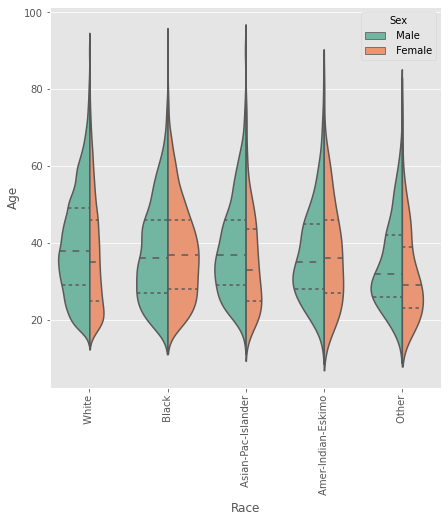

In [42]:
plt.figure(figsize=(7,7))
sns.violinplot(x="Race", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.xticks(rotation=90)
plt.show()

Above violin plot shows us that female with black ethinicity of any age group is higher than the other ethinicity group females.

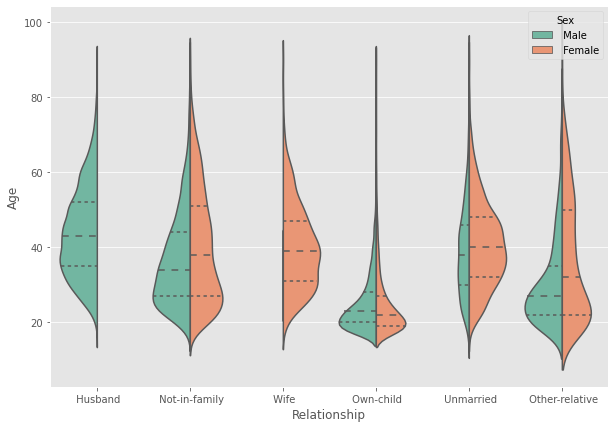

In [43]:
plt.figure(figsize=(10,7))
sns.violinplot(x="Relationship", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that people in the own child relationship age from 10-40. Also we have female who are unmarried more than the male counter parts.

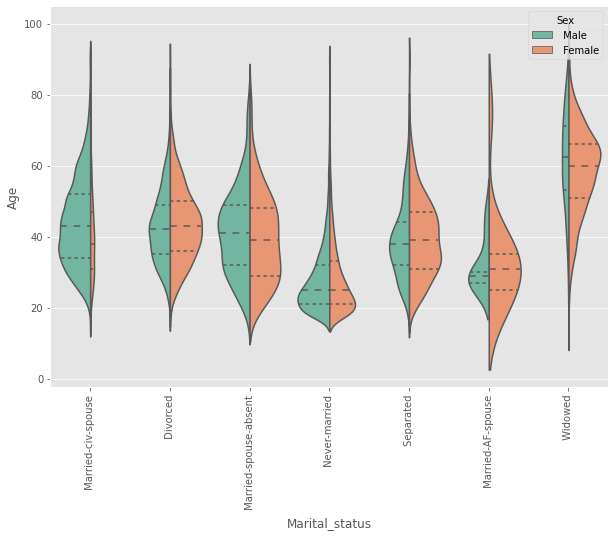

In [44]:
plt.figure(figsize=(10,7))
sns.violinplot(x="Marital_status", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.xticks(rotation=90)
plt.show()

Above violin plot shows us that the marital status as married spouse have a higher number in male than in female and people who are widowed have a higher number in females as compared to the males.

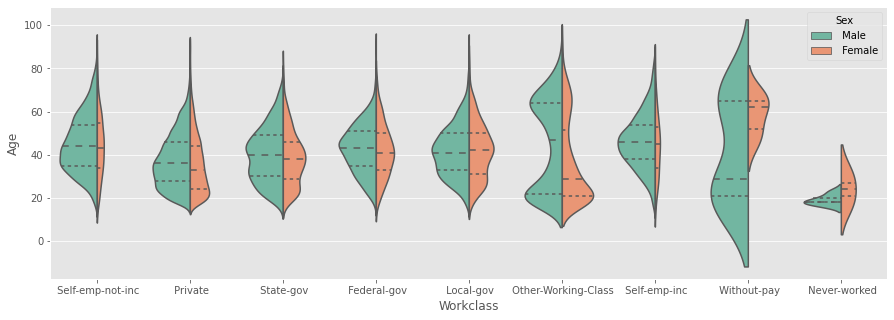

In [45]:
plt.figure(figsize=(15,5))
sns.violinplot(x="Workclass", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that male cover most of the working class sectors in each category as compared to the females.

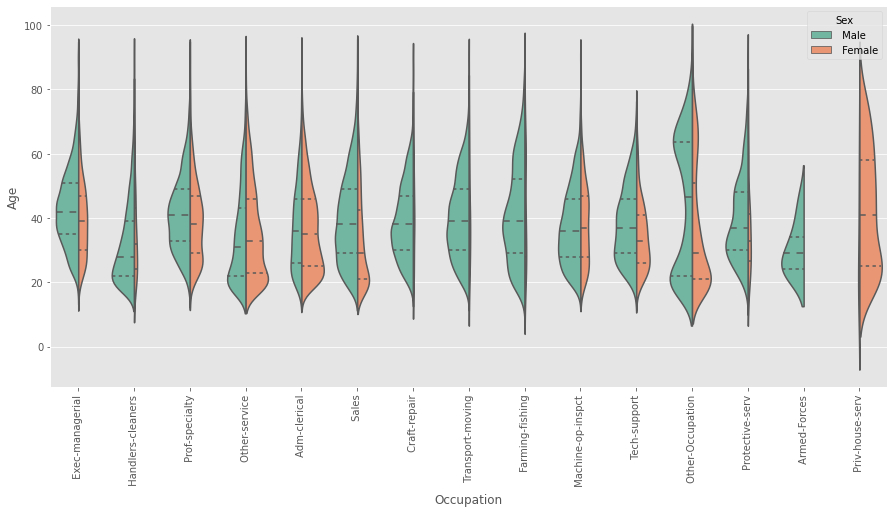

In [46]:
plt.figure(figsize=(15,7))
sns.violinplot(x="Occupation", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.xticks(rotation=90)
plt.show()

Above violin plot shows us that the designation of private house services has more number of female mostly from the 20-60 age group while occupations such as craft repair, transport moving, farming/fishing, protective/security service and armed forces have a larger number of data coverage for males.

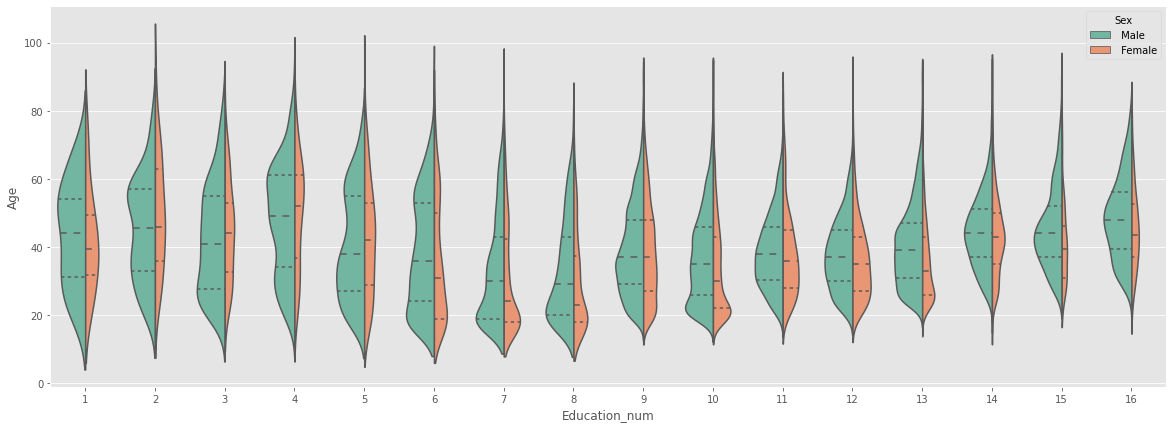

In [47]:
plt.figure(figsize=(20,7))
sns.violinplot(x="Education_num", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that males in all age group have a higher education number compared to their female counter parts.

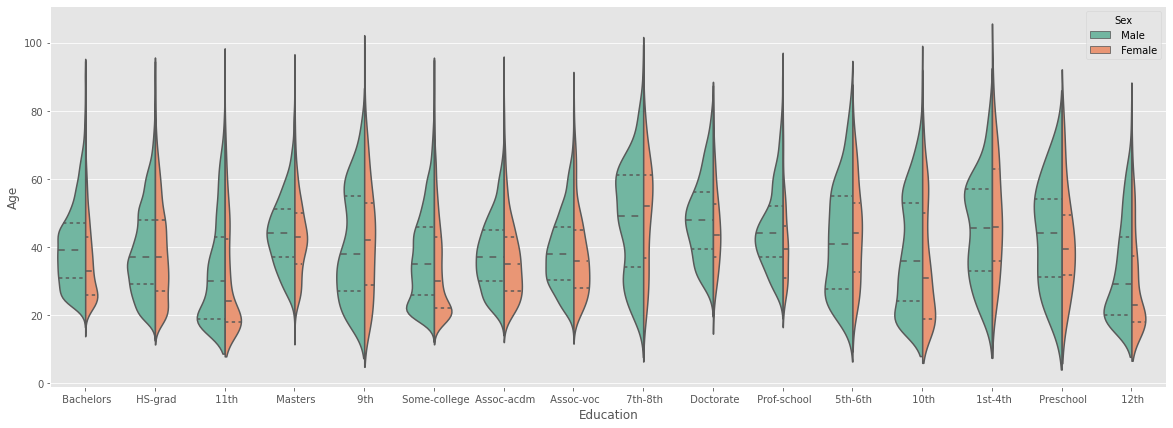

In [48]:
plt.figure(figsize=(20,7))
sns.violinplot(x="Education", y="Age", hue="Sex", data=df, 
               palette="Set2", split=True, scale="count", inner="quartile")
plt.show()

Above violin plot shows us that just like the education number the education category sees more number of males than their female counter parts.

## Encoding the categorical object datatype columns

In [49]:
# Label Encoder

le = LabelEncoder()
df["Income"] = le.fit_transform(df["Income"])
df.head()

Age          Workclass  Fnlwgt   Education  Education_num  \
0   50   Self-emp-not-inc   83311   Bachelors             13   
1   38            Private  215646     HS-grad              9   
2   53            Private  234721        11th              7   
3   28            Private  338409   Bachelors             13   
4   37            Private  284582     Masters             14   

        Marital_status          Occupation    Relationship    Race      Sex  \
0   Married-civ-spouse     Exec-managerial         Husband   White     Male   
1             Divorced   Handlers-cleaners   Not-in-family   White     Male   
2   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
3   Married-civ-spouse      Prof-specialty            Wife   Black   Female   
4   Married-civ-spouse     Exec-managerial            Wife   White   Female   

   Capital_gain  Capital_loss  Hours_per_week  Native_country  Income  
0             0             0              13   United-States       0  
1             0             0              40   United-States       0  
2             0             0              40   United-States       0  
3             0             0              40            Cuba       0  
4             0             0              40   United-States       0

I have used LabelEncoder to convert the object data type in our label column "Income" (target) to a numerical format.

In [50]:
# Ordinal Encoder

oe = OrdinalEncoder()
df['Workclass'] = oe.fit_transform(df['Workclass'].values.reshape(-1,1))
df['Education'] = oe.fit_transform(df['Education'].values.reshape(-1,1))
df['Marital_status'] = oe.fit_transform(df['Marital_status'].values.reshape(-1,1))
df['Occupation'] = oe.fit_transform(df['Occupation'].values.reshape(-1,1))
df['Relationship'] = oe.fit_transform(df['Relationship'].values.reshape(-1,1))
df['Native_country'] = oe.fit_transform(df['Native_country'].values.reshape(-1,1))
df['Race'] = oe.fit_transform(df['Race'].values.reshape(-1,1))
df['Sex'] = oe.fit_transform(df['Sex'].values.reshape(-1,1))
df.head()

Age  Workclass  Fnlwgt  Education  Education_num  Marital_status  \
0   50        6.0   83311        9.0             13             2.0   
1   38        4.0  215646       11.0              9             0.0   
2   53        4.0  234721        1.0              7             2.0   
3   28        4.0  338409        9.0             13             2.0   
4   37        4.0  284582       12.0             14             2.0   

   Occupation  Relationship  Race  Sex  Capital_gain  Capital_loss  \
0         3.0           0.0   4.0  1.0             0             0   
1         5.0           1.0   4.0  1.0             0             0   
2         5.0           0.0   2.0  1.0             0             0   
3        10.0           5.0   2.0  0.0             0             0   
4         3.0           5.0   4.0  0.0             0             0   

   Hours_per_week  Native_country  Income  
0              13            39.0       0  
1              40            39.0       0  
2              40            39.0       0  
3              40             4.0       0  
4              40            39.0       0

I could have used one hot encoder here but I preferred to use OrdinalEncoder to ensure that the number of columns do not get increased unnecessarily.

In [51]:
print(f"Shape of our data frame post encoding is", df.shape)
df.isnull().sum()

Shape of our data frame post encoding is (32536, 15)


Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_num     0
Marital_status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_gain      0
Capital_loss      0
Hours_per_week    0
Native_country    0
Income            0
dtype: int64

I am checking the number of rows and columns present in our dataset after applying the enconding techniques and ensuring that there are no null values present in them.

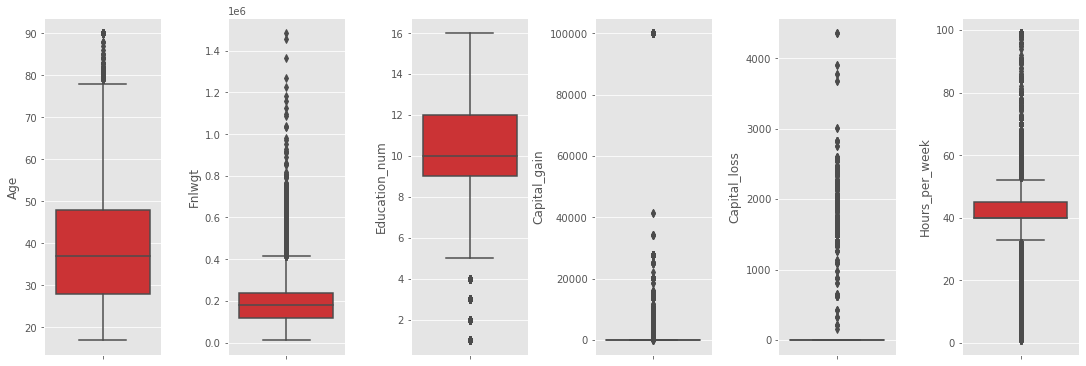

In [52]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[integer_datatype].items():
    sns.boxplot(y=col, data=df, ax=ax[index], palette="Set1")
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of box plot we can see the outlier details present in our numerical data columns which will need to be treated.

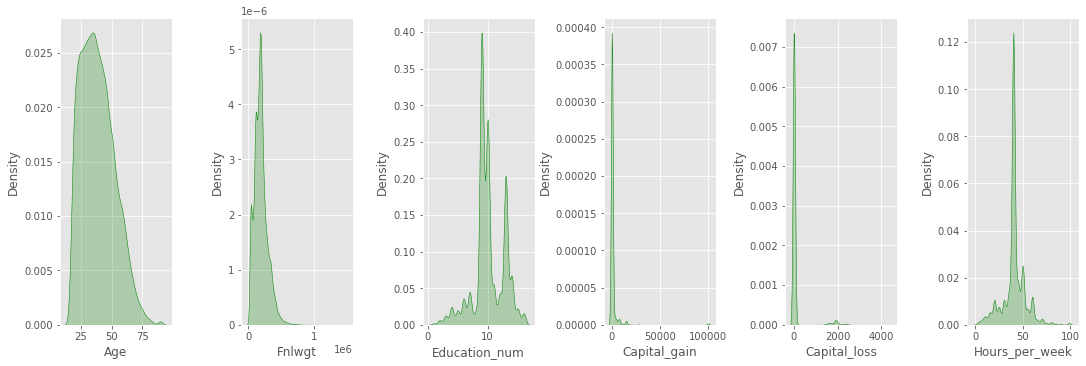

In [53]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(15,5))
index = 0
ax = ax.flatten()
for col, value in df[integer_datatype].items():
    sns.distplot(value, ax=ax[index], hist=False, color="g", kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of distribution plot we can see the skewness details present in our numerical data columns which will need to be treated.

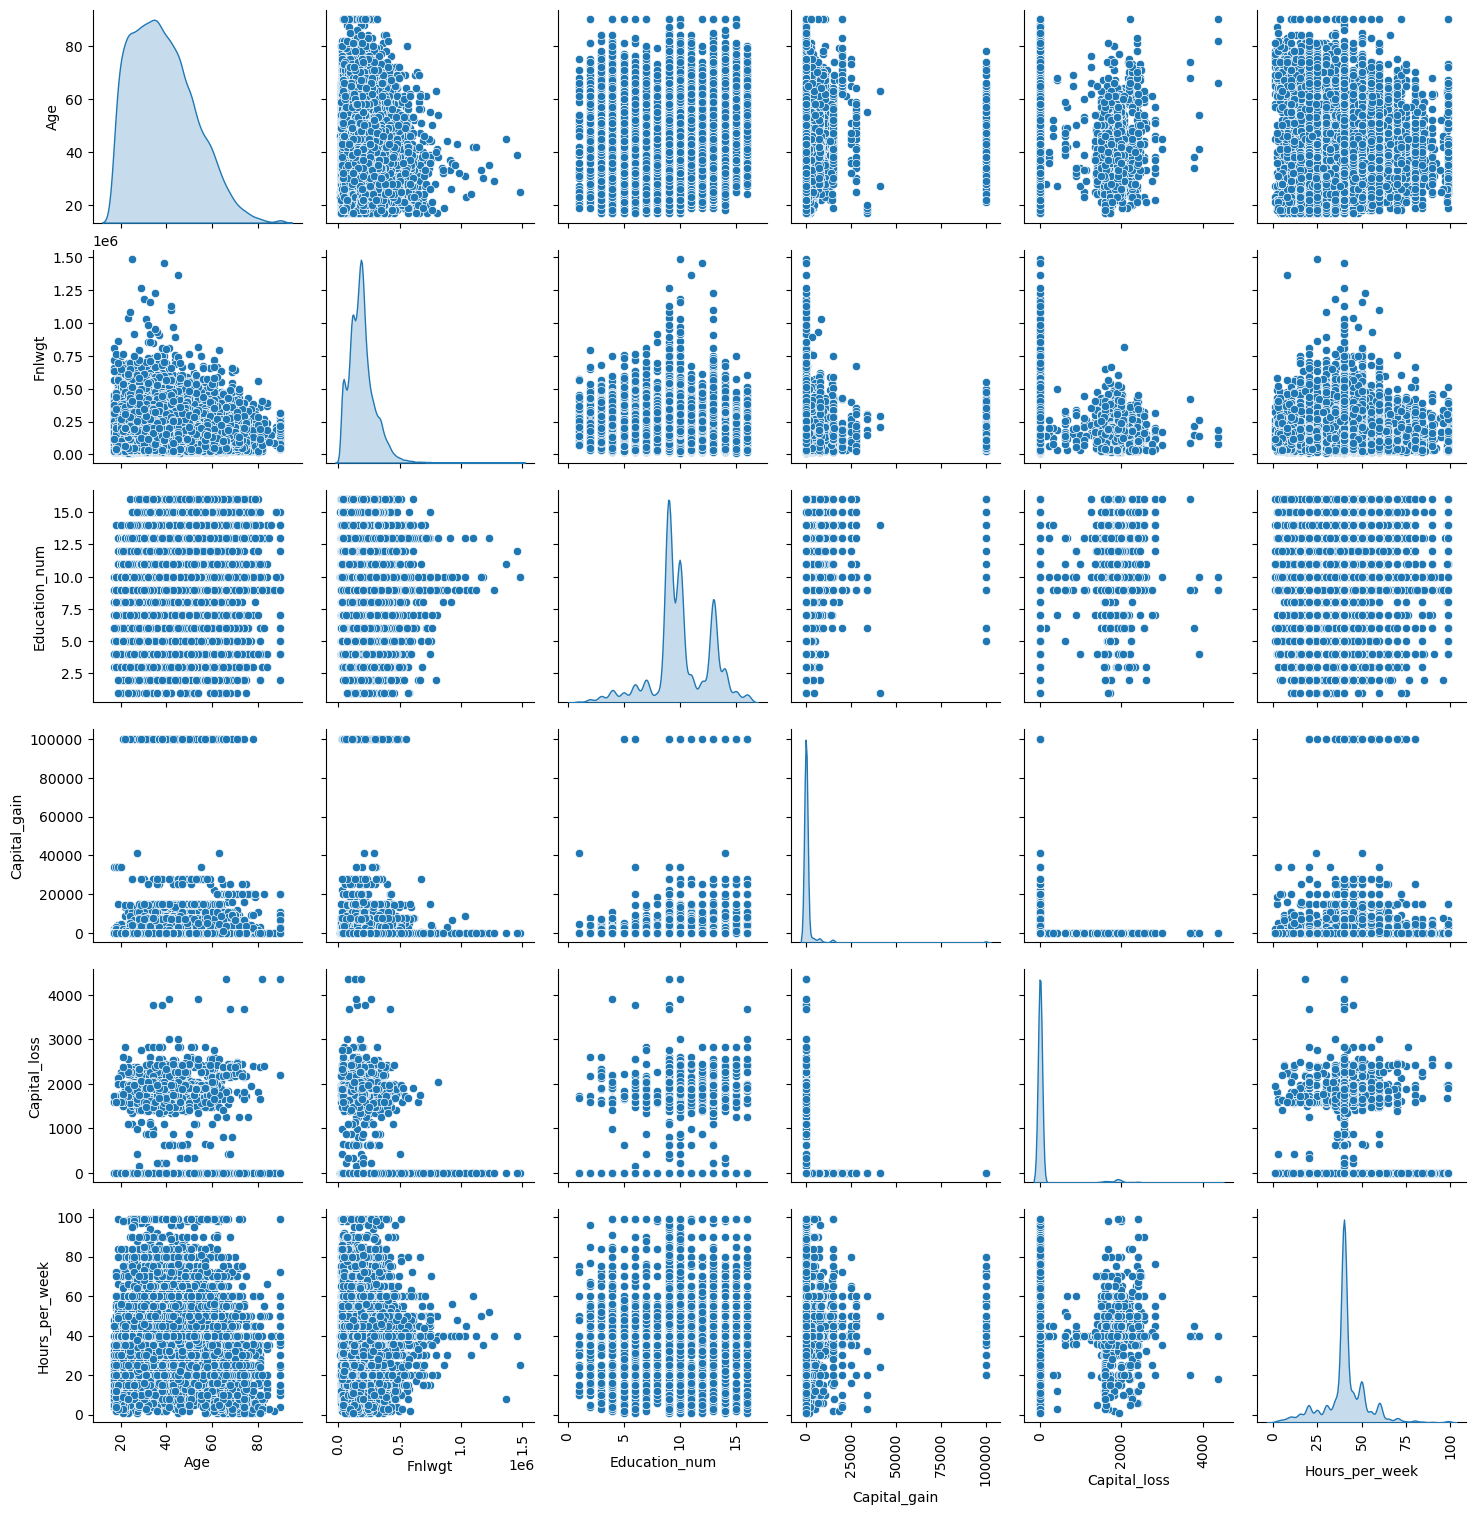

In [54]:
num_values = df.drop(['Workclass', 'Education', 'Marital_status', 'Occupation', 'Relationship', 'Race', 'Sex',
                      'Native_country', 'Income'], axis=1)
plt.style.use('default')
g = sns.pairplot(num_values, diag_kind="kde")
for ax in g.axes.flat:
    ax.tick_params("x", labelrotation=90)
plt.show()

I have generated the above pairplot for our continous data columns and show us how the data points are available in each of them.

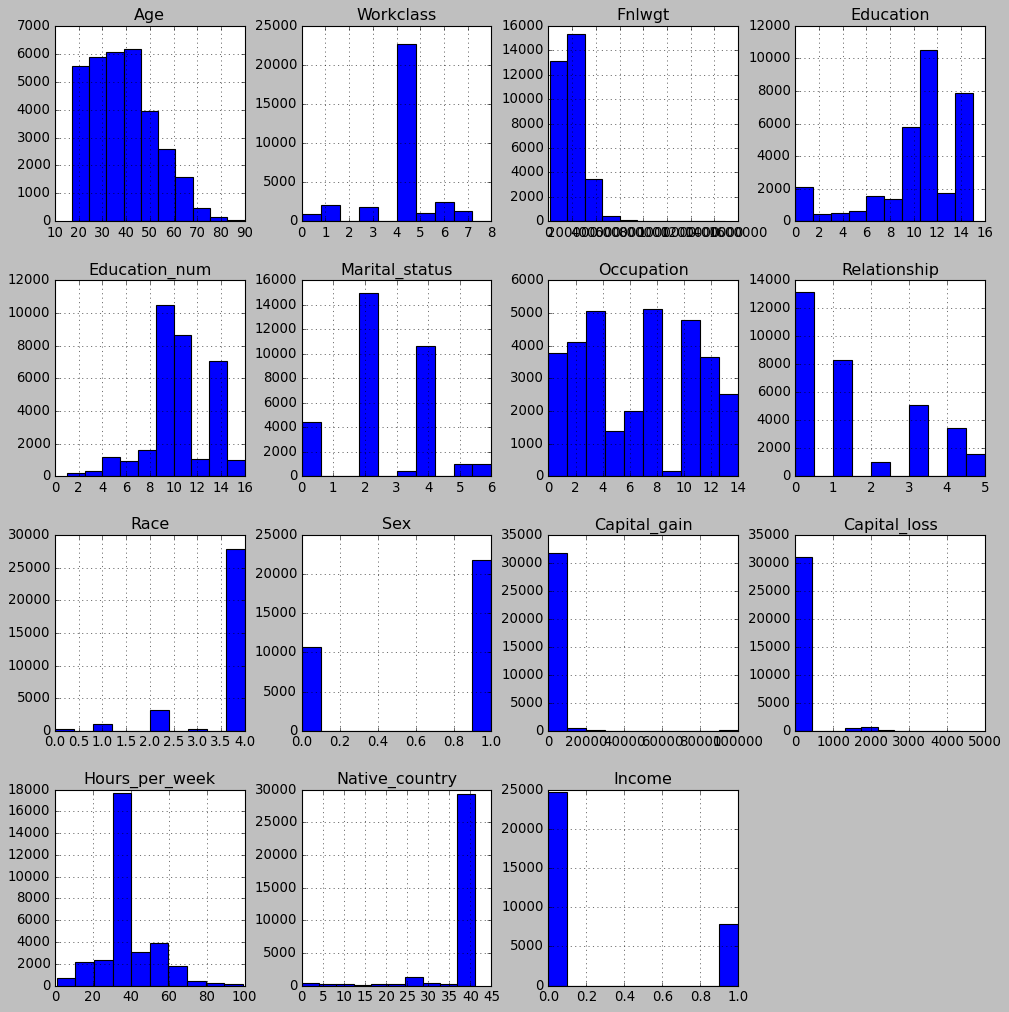

In [55]:
plt.style.use('classic')
df.hist(figsize=(15,15))
plt.show()

I have generated a histogram for all our dataset columns after applying enconding and converting object datatype to numeric datatype values.

# Correlation using a Heatmap

- Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.
- Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

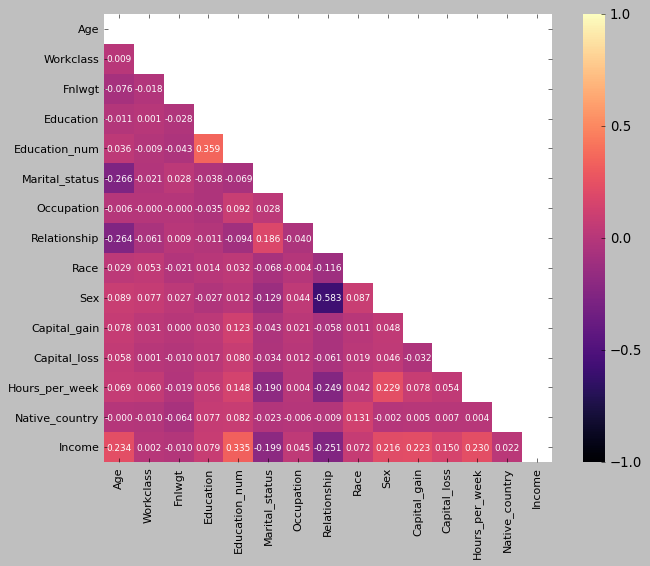

In [57]:
plt.style.use('seaborn-pastel')
upper_triangle = np.triu(df.corr())
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', 
            annot_kws={'size':8}, cmap="magma", mask=upper_triangle)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In the above heatmap we can see the correlation details plus we can determine that there is no multi colinearity issue between our columns.

# Correlation Bar Plot comparing features with our label

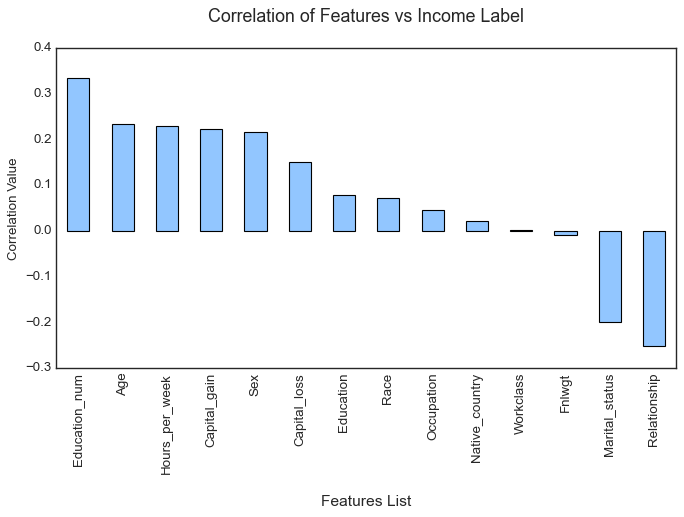

In [58]:
plt.style.use('seaborn-white')
df_corr = df.corr()
plt.figure(figsize=(10,5))
df_corr['Income'].sort_values(ascending=False).drop('Income').plot.bar()
plt.title("Correlation of Features vs Income Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

Since the heatmap was not able to give us a clear picture on positive and negative correlation columns we have generated this bar plot and we see that columns relationship and marital status are the only one's negatively correlated rest all the other feature columns are positively correlated with our label column.

# Using Z Score to remove outliers

In [59]:
z = np.abs(zscore(df))
threshold = 3
df1 = df[(z<3).all(axis = 1)]

print ("Shape of the dataframe before removing outliers: ", df.shape)
print ("Shape of the dataframe after removing outliers: ", df1.shape)
print ("Percentage of data loss post outlier removal: ", (df.shape[0]-df1.shape[0])/df.shape[0]*100)

df=df1.copy() # reassigning the changed dataframe name to our original dataframe name

Shape of the dataframe before removing outliers:  (32536, 15)
Shape of the dataframe after removing outliers:  (27763, 15)
Percentage of data loss post outlier removal:  14.669904106220802


I have used the Z score method to remove the outliers and even though we are losing 14.6699 % of data I am able to afford that loss considering we have a lot of rows in our datatset to be used while model building.

In [60]:
df.skew()

Age                0.484855
Workclass         -0.663507
Fnlwgt             0.629184
Education         -0.955853
Education_num     -0.145432
Marital_status    -0.045123
Occupation         0.101481
Relationship       0.753529
Race              -2.585947
Sex               -0.689396
Capital_gain       4.929937
Capital_loss      29.510814
Hours_per_week    -0.358912
Native_country    -4.368853
Income             1.321803
dtype: float64

With the skew method we see that there are columns present in our dataset that are above the acceptable range of +/-0.5 value.

## Using Log Transform to fix skewness

In [62]:
for col in integer_datatype:
    if df.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

I have applied Log Transformation on our numerical integer datatype columns to ensure that we do not have skewness in our dataset.

In [63]:
df.skew()

Age                0.484855
Workclass         -0.663507
Fnlwgt            -0.955984
Education         -0.955853
Education_num     -0.145432
Marital_status    -0.045123
Occupation         0.101481
Relationship       0.753529
Race              -2.585947
Sex               -0.689396
Capital_gain       3.111123
Capital_loss      25.003969
Hours_per_week    -0.358912
Native_country    -4.368853
Income             1.321803
dtype: float64

We have managed to reduce the skewness from our numerical columns and that can be seen above while we have ignored the skewness and outlier details for our categorical data.

## Splitting the dataset into features and Target

In [64]:
X = df.drop('Income', axis=1)
Y = df['Income']

I have bifurcated the dataset into features and labels where X represents all the feature columns and Y represents the target label column.

# SMOTE

### Resolving the class imbalance issue in our label column

In [65]:
Y.value_counts()

0    21535
1     6228
Name: Income, dtype: int64

Listing the values of our label column to count the number of rows occupied by each category. This indicates class imbalance that we will need to fix by using the oversampling method.

In [66]:
# adding samples to make all the categorical label values same

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

SMOTE is the over sampling mechanism that we are using to ensure that all the categories present in our target label have the same value.

In [67]:
Y.value_counts()

0    21535
1    21535
Name: Income, dtype: int64

After applying over sampling we are once again listing the values of our label column to cross verify the updated information. Here we see that we have successfully resolved the class imbalance problem and now all the categories have same data ensuring that the machine learning model does not get biased towards one category.

## Feature Scaling

In [68]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

Age  Workclass    Fnlwgt  Education  Education_num  Marital_status  \
0  0.780547   1.549154 -1.145002  -0.427335       1.010176       -0.319686   
1 -0.170096   0.050092  0.521901   0.141630      -0.636056       -1.856275   
2  1.018207   0.050092  0.670458  -2.703193      -1.459172       -0.319686   
3 -0.249317   0.050092  1.008068   0.426112       1.421733       -0.319686   
4  0.701326   0.050092  0.000834  -1.280781      -2.282288        0.448608   

   Occupation  Relationship      Race       Sex  Capital_gain  Capital_loss  \
0   -0.809291     -0.729763  0.308990  0.607152     -0.383662     -0.033338   
1   -0.352112     -0.108848  0.308990  0.607152     -0.383662     -0.033338   
2   -0.352112     -0.729763 -3.482534  0.607152     -0.383662     -0.033338   
3   -0.809291      2.374815  0.308990 -1.691005     -0.383662     -0.033338   
4    0.333656     -0.108848 -3.482534 -1.691005     -0.383662     -0.033338   

   Hours_per_week  Native_country  
0       -2.657674        0.211665  
1       -0.151119        0.211665  
2       -0.151119        0.211665  
3       -0.151119        0.211665  
4       -2.379168       -5.852868

I am scaling my feature data to ensure that there is no issue with the data biasness over a particular column instead a standardization will occur helping us in having a uniform dataset value.

# Machine Learning

### Finding best random state

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
LR = LogisticRegression()

For 0.25 test size

In [71]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LogisticRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    acc_score = (accuracy_score(Y_test, pred))*100
    
    if acc_score>maxAccu:
        maxAccu=acc_score
        maxRS=i

print("Best accuracy score is", maxAccu,"on Random State", maxRS)

Best accuracy score is 77.63744427934621 on Random State 336


For 0.2 test size

In [72]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=i)
    lr=LogisticRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    acc_score = (accuracy_score(Y_test, pred))*100
    
    if acc_score>maxAccu:
        maxAccu=acc_score
        maxRS=i

print("Best accuracy score is", maxAccu,"on Random State", maxRS)

Best accuracy score is 77.71070350592059 on Random State 768


In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
maxAccu=0
maxRS=0

for i in range(1,200):
    x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=.20, random_state=i)
    rfc=RandomForestClassifier()
    rfc.fit(x_train,y_train)
    pred=rfc.predict(x_test)
    acc=accuracy_score(y_test,pred)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is ",maxAccu," on Random_state ",maxRS)

Best accuracy is  0.9079405618760158  on Random_state  36


Referring all the above We have found best random_state value as 36. We will create our train_test_split using this random_state

### Feature importance bar graph

Importance
Features                  
Relationship         0.173
Marital_status       0.147
Age                  0.144
Fnlwgt               0.121
Occupation           0.074
Education_num        0.068
Hours_per_week       0.066
Capital_gain         0.063
Education            0.049
Workclass            0.045
Sex                  0.027
Race                 0.014
Native_country       0.008
Capital_loss         0.000

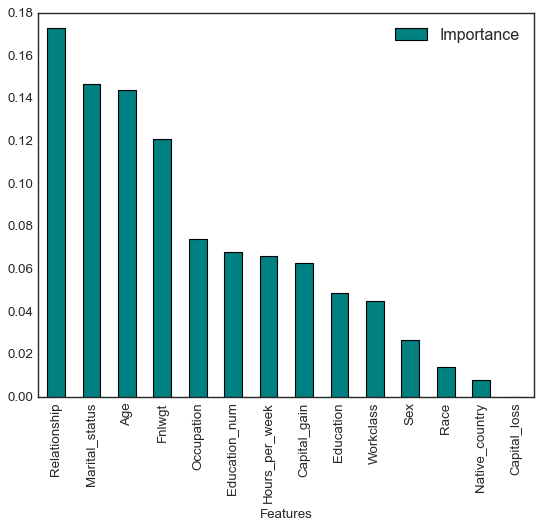

In [75]:
rf=RandomForestClassifier()
rf.fit(X_train, Y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='teal')
importances

Here with the help of RandomForestClassifier we are able to list down the importance or priority given to a column as per it's involvement or weightage in predicting our label.

## Machine Learning Model for Classification

In [122]:
# Importing required libraries
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [81]:
# creating a function to run all the classifiers

def classifier(model, X, Y):
    x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state=36)
    
    # Training the model
    model.fit(x_train, y_train)
    
    # Predicting y_test
    pred = model.predict(x_test)
    
    # Accuracy Score
    acc_score = (accuracy_score(y_test, pred))*100
    print("Accuracy Score:", acc_score)
    
    # Classification Report
    class_report = classification_report(y_test, pred)
    print("\nClassification Report:\n", class_report)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of accuracy minus cv scores
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is", result)

### Logistic Regression

In [82]:
model = LogisticRegression()
classifier(model, X, Y)

Accuracy Score: 77.1882981193406

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77      4386
           1       0.76      0.79      0.77      4228

    accuracy                           0.77      8614
   macro avg       0.77      0.77      0.77      8614
weighted avg       0.77      0.77      0.77      8614

Cross Validation Score: 76.6217785001161

Accuracy Score - Cross Validation Score is 0.5665196192245077


### Naive Bayes

In [83]:
model = GaussianNB()
classifier(model, X, Y)

Accuracy Score: 78.24471790109125

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.73      0.77      4386
           1       0.75      0.84      0.79      4228

    accuracy                           0.78      8614
   macro avg       0.79      0.78      0.78      8614
weighted avg       0.79      0.78      0.78      8614

Cross Validation Score: 77.61783143719526

Accuracy Score - Cross Validation Score is 0.6268864638959855


### SVC Classifier

In [84]:
model = SVC(kernel='rbf')
classifier(model, X, Y)

Accuracy Score: 84.33944741119109

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.79      0.84      4386
           1       0.80      0.90      0.85      4228

    accuracy                           0.84      8614
   macro avg       0.85      0.84      0.84      8614
weighted avg       0.85      0.84      0.84      8614

Cross Validation Score: 84.05850940329695

Accuracy Score - Cross Validation Score is 0.2809380078941359


In [85]:
model = SVC(kernel='linear')
classifier(model, X, Y)

Accuracy Score: 77.30438820524728

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.73      0.77      4386
           1       0.75      0.81      0.78      4228

    accuracy                           0.77      8614
   macro avg       0.78      0.77      0.77      8614
weighted avg       0.78      0.77      0.77      8614

Cross Validation Score: 76.83306245646622

Accuracy Score - Cross Validation Score is 0.47132574878105515


In [86]:
model = SVC(kernel='poly')
classifier(model, X, Y)

Accuracy Score: 81.6113303923845

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80      4386
           1       0.76      0.92      0.83      4228

    accuracy                           0.82      8614
   macro avg       0.83      0.82      0.81      8614
weighted avg       0.83      0.82      0.81      8614

Cross Validation Score: 81.26306013466451

Accuracy Score - Cross Validation Score is 0.34827025771998876


### Decision Tree Classifier

In [89]:
model = DecisionTreeClassifier()
classifier(model, X, Y)

Accuracy Score: 86.66124912932436

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      4386
           1       0.86      0.88      0.87      4228

    accuracy                           0.87      8614
   macro avg       0.87      0.87      0.87      8614
weighted avg       0.87      0.87      0.87      8614

Cross Validation Score: 85.63269096819133

Accuracy Score - Cross Validation Score is 1.0285581611330343


### KNeighbors Classifier

In [90]:
model = KNeighborsClassifier()
classifier(model, X, Y)

Accuracy Score: 86.01114464824704

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85      4386
           1       0.82      0.92      0.87      4228

    accuracy                           0.86      8614
   macro avg       0.86      0.86      0.86      8614
weighted avg       0.87      0.86      0.86      8614

Cross Validation Score: 85.18458323659159

Accuracy Score - Cross Validation Score is 0.8265614116554474


### SGD Classifier

In [91]:
model = SGDClassifier()
classifier(model, X, Y)

Accuracy Score: 76.71232876712328

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77      4386
           1       0.75      0.79      0.77      4228

    accuracy                           0.77      8614
   macro avg       0.77      0.77      0.77      8614
weighted avg       0.77      0.77      0.77      8614

Cross Validation Score: 76.31065706988622

Accuracy Score - Cross Validation Score is 0.4016716972370631


### Random Forest Classifier

In [92]:
model = RandomForestClassifier(random_state=36)
classifier(model, X, Y)

Accuracy Score: 90.78244717901092

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      4386
           1       0.90      0.92      0.91      4228

    accuracy                           0.91      8614
   macro avg       0.91      0.91      0.91      8614
weighted avg       0.91      0.91      0.91      8614

Cross Validation Score: 89.78175063849547

Accuracy Score - Cross Validation Score is 1.0006965405154489


In [93]:
model = RandomForestClassifier()
classifier(model, X, Y)

Accuracy Score: 90.68957511028557

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      4386
           1       0.90      0.92      0.91      4228

    accuracy                           0.91      8614
   macro avg       0.91      0.91      0.91      8614
weighted avg       0.91      0.91      0.91      8614

Cross Validation Score: 89.73763640585094

Accuracy Score - Cross Validation Score is 0.9519387044346388


### ExtraTrees Classifier

In [94]:
model = ExtraTreesClassifier(random_state=36)
classifier(model, X, Y)

Accuracy Score: 90.80566519619224

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91      4386
           1       0.89      0.92      0.91      4228

    accuracy                           0.91      8614
   macro avg       0.91      0.91      0.91      8614
weighted avg       0.91      0.91      0.91      8614

Cross Validation Score: 90.2855816113304

Accuracy Score - Cross Validation Score is 0.5200835848618368


In [95]:
model = ExtraTreesClassifier()
classifier(model, X, Y)

Accuracy Score: 90.67796610169492

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91      4386
           1       0.89      0.92      0.91      4228

    accuracy                           0.91      8614
   macro avg       0.91      0.91      0.91      8614
weighted avg       0.91      0.91      0.91      8614

Cross Validation Score: 90.3064778267936

Accuracy Score - Cross Validation Score is 0.3714882749013242


### AdaBoost Classifier

In [96]:
model = AdaBoostClassifier()
classifier(model, X, Y)

Accuracy Score: 86.42906895751102

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.86      4386
           1       0.84      0.89      0.87      4228

    accuracy                           0.86      8614
   macro avg       0.87      0.86      0.86      8614
weighted avg       0.87      0.86      0.86      8614

Cross Validation Score: 85.87183654515904

Accuracy Score - Cross Validation Score is 0.5572324123519792


### Gradient Boosting Classifier

In [97]:
model = GradientBoostingClassifier()
classifier(model, X, Y)

Accuracy Score: 87.62479684234967

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.85      0.87      4386
           1       0.85      0.91      0.88      4228

    accuracy                           0.88      8614
   macro avg       0.88      0.88      0.88      8614
weighted avg       0.88      0.88      0.88      8614

Cross Validation Score: 86.95147434409101

Accuracy Score - Cross Validation Score is 0.6733224982586563


Comparing all the above the ExtraTreesClassifier gives the best results since the Accuracy Score - Cross Validation Score is the least along with higher Cross Validation Score and the highest Accuracy Score comparing all the models.

# Hyper Parameter Tuning

In [98]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.20,random_state=36)

In [99]:
x_test.shape

(8614, 14)

In [100]:
y_test.shape

(8614,)

In [101]:
x_train.shape

(34456, 14)

In [102]:
y_train.shape

(34456,)

In [106]:
ExtraTreesClassifier?

In [107]:
# creating parameters list to pass into GridSearchCV

parameters = {'criterion' : ['gini', 'entropy'],
              'max_features' : ['auto', 'sqrt', 'log2'],
              'n_jobs' : [5, 10],
              'random_state' : [None, 36]}

In [108]:
GCV = GridSearchCV(ExtraTreesClassifier(), parameters, cv=5)

In [109]:
GCV.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=ExtraTreesClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_jobs': [5, 10], 'random_state': [None, 36]})

In [110]:
GCV.best_params_      # printing best parameters found by GridSearchCV

{'criterion': 'entropy',
 'max_features': 'log2',
 'n_jobs': 10,
 'random_state': None}

We got the best parameters using Gridsearch CV

In [111]:
final_modelc = ExtraTreesClassifier(criterion = 'entropy', max_features = 'log2', n_jobs = 10, random_state = None)   # final model with best parameters

In [112]:
final_fitc = final_modelc.fit(x_train,y_train)   # final fit

In [113]:
final_predc = final_modelc.predict(x_test)   # predicting with best parameters

In [114]:
best_acc_score = (accuracy_score(y_test, final_predc))*100    # checking accuracy score
print("The Accuracy Score for the Best Model is ", best_acc_score)

The Accuracy Score for the Best Model is  90.70118411887624


We successfully performed the Hyper Parameter Tuning on the Final Model.

In [115]:
# Final Cross Validation Score
final_cv_score = (cross_val_score(final_modelc, X, Y, cv=5).mean())*100
print("Cross Validation Score:", final_cv_score)

Cross Validation Score: 90.31576503366611


We got final accuracy score of 90.70118% and Cross Validation Score of 90.31576% which is good

In [116]:
# Final Classification Report
final_class_report = classification_report(y_test, final_predc)
print("\nClassification Report:\n", final_class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.89      0.91      4386
           1       0.89      0.92      0.91      4228

    accuracy                           0.91      8614
   macro avg       0.91      0.91      0.91      8614
weighted avg       0.91      0.91      0.91      8614



## Confusion Matrix

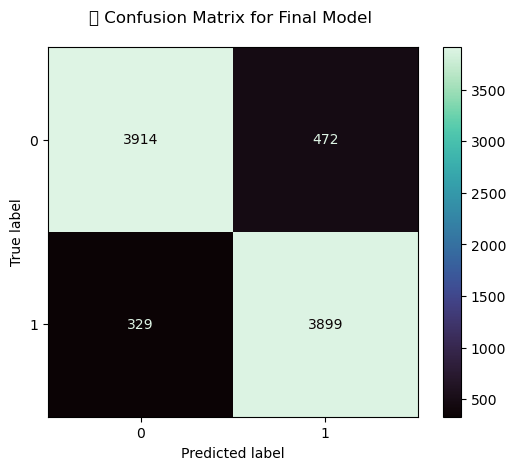

In [124]:
plt.style.use('default')
class_names = df.columns
metrics.plot_confusion_matrix(final_modelc, x_test, y_test, cmap='mako')
plt.title('\t Confusion Matrix for Final Model \n')
plt.show()

With the help of above confusion matrix I am able to understand the number of times I got the correct outputs and the number of times my ML model missed to provide the correct prediction (depicting in the black boxes).

# AUC ROC curve

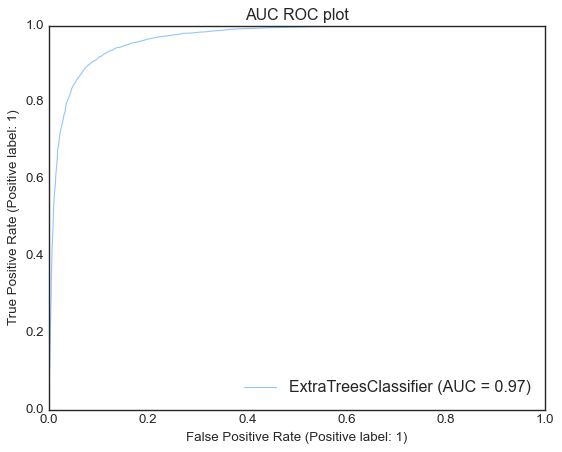

In [117]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(final_modelc, x_test, y_test)
plt.title("AUC ROC plot")
plt.show()

We got final accuracy score of 90.70118% and Cross Validation Score of 90.31576% and also AUC score is 0.97 which is really good.

# Saving the model in pickle Format

In [118]:
# pickeling or serialization of a file
import pickle
filename = 'Census_Income_Project_Final_Model.pkl'
pickle.dump(final_modelc, open(filename, 'wb'))

# Prediction Conclusion:

In [119]:
import numpy as np
ac=np.array(y_test)
predictedc=np.array(final_modelc.predict(x_test))
df_comparisonc = pd.DataFrame({"original":ac,"predicted":predictedc},index= range(len(ac)))
df_comparisonc

original  predicted
0            1          1
1            1          1
2            0          0
3            1          1
4            1          1
5            0          1
6            1          1
7            0          0
8            1          1
9            0          0
10           0          0
11           1          1
12           0          0
13           0          0
14           0          0
15           1          1
16           0          0
17           0          0
18           1          1
19           0          0
20           0          1
21           0          0
22           1          1
23           1          1
24           0          0
25           0          0
26           1          1
27           0          0
28           0          0
29           0          0
30           0          1
31           1          0
32           1          1
33           1          1
34           0          0
35           1          1
36           1          0
37           0          0
38           0          0
39           0          0
40           1          1
41           1          1
42           0          0
43           0          0
44           1          1
45           0          0
46           0          0
47           1          1
48           0          0
49           0          0
50           0          0
51           1          1
52           1          1
53           0          0
54           0          0
55           0          0
56           1          1
57           1          1
58           0          0
59           1          0
60           0          0
61           1          1
62           1          1
63           1          1
64           0          0
65           0          0
66           0          0
67           1          1
68           1          1
69           1          0
70           0          1
71           1          1
72           1          1
73           0          0
74           0          0
75           1          1
76           0          0
77           1          1
78           1          1
79           1          1
80           0          0
81           0          1
82           0          0
83           1          1
84           1          0
85           1          1
86           1          1
87           0          0
88           0          0
89           0          0
90           1          1
91           1          1
92           0          0
93           0          0
94           1          0
95           0          1
96           1          1
97           0          0
98           0          0
99           1          1
100          0          0
101          1          1
102          0          0
103          0          0
104          1          1
105          0          0
106          0          0
107          0          0
108          0          0
109          0          0
110          1          1
111          0          0
112          1          1
113          1          1
114          1          1
115          0          0
116          1          1
117          0          0
118          1          1
119          1          1
120          1          1
121          1          1
122          1          0
123          0          1
124          1          1
125          0          0
126          1          1
127          1          1
128          1          1
129          0          0
130          1          1
131          0          0
132          1          1
133          0          0
134          1          1
135          0          0
136          0          0
137          0          0
138          0          1
139          1          1
140          0          1
141          0          0
142          0          0
143          0          0
144          0          0
145          1          1
146          1          1
147          1          1
148          0          0
149          0          0
150          0          1
151          0          0
152          0          1
15

Hence predicted the "Income" using the final Model.

Saving the comparison file as a csv file.

In [120]:
df_comparisonc.to_csv('Census_Income_Project_Prediction.csv')

Saved the file as a csv.

# Thank You